In [93]:
# pip install --upgrade pystac-client

In [94]:
# pip show pystac_client

In [95]:
# imports
import pystac_client
import xarray as xr
import matplotlib.pyplot as plt
import pathlib
import os
import numpy as np
import geopandas as gpd
import matplotlib as mpl
from matplotlib import colors
import rasterio

import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px
from rasterio.plot import show

import matplotlib.colors as mcolors
from shapely.geometry import Point
import pandas as pd

from tqdm import tqdm


In [96]:
# opening STAC catalog, either a url, cloud storage link or a local (cloned) folder
cwd = pathlib.Path().resolve()

catalog = pystac_client.Client.open(
    "https://services.terrascope.be/stac/" # cloud API
    #os.path.join(os.path.dirname(cwd), "stac_folder", "current", "catalog.json") # local clone 
)
catalog

<Client id=terrascope>

In [97]:
list(catalog.get_children())

[<CollectionClient id=urn:eop:VITO:CGS_S1_GRD_L1>,
 <CollectionClient id=urn:eop:VITO:CGS_S1_GRD_SIGMA0_L1>,
 <CollectionClient id=urn:eop:VITO:CGS_S1_SLC_L1>,
 <CollectionClient id=urn:eop:VITO:CGS_S2_L1C>,
 <CollectionClient id=urn:eop:VITO:COP_DEM_EU_25M>,
 <CollectionClient id=urn:eop:VITO:COP_DEM_GLO_30M_COG>,
 <CollectionClient id=urn:eop:VITO:COP_DEM_GLO_90M_COG>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_ACTIVECROPLAND_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_IRRIGATION_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_MAIZE_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_SPRINGCEREALS_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_TEMPORARYCROPS_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_WINTERCEREALS_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WorldCover_10m_2020_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2>,
 <CollectionCli

In [98]:
collection= catalog.get_child("urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1")
collection

<CollectionClient id=urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1>

In [99]:
# b=list(catalog.get_collections())
# for collec in b:
#     print(f"{collec.id}")

In [100]:
items=list(collection.get_all_items())
print(f"Number of items: {len(items)}")
for item in items:
    print(f"- {item.id}")

Number of items: 100
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E006
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E009
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E012
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E015
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E018
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E021
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E024
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E027
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E030
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E033
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E036
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2

In [101]:
# World cover goes up in increments of 3 degrees

import math
tile_size=3
tile_prefix="urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_"

 


def find_tile_name(lat,lon,tile_size,tile_prefix):
    if lon>0:
        sign_lon="E"
    else:
        sign_lon="W"
    if lat>0:
        sign_lat="N"
    else:
        sign_lat="S"
    if abs(lat)<10:
        newlat="0"+str(abs(math.floor(lat/tile_size)*tile_size))
    else:
        newlat=str(abs(math.floor(lat/tile_size)*tile_size))

    if abs(lon)<10:
        newlon="00"+str(abs(math.floor(lon/tile_size)*tile_size))   
    elif abs(lon)<100:
        newlon="0"+str(abs(math.floor(lon/tile_size)*tile_size))
    else:
        newlon=str(abs(math.floor(lon/tile_size)*tile_size))
        
    tile_name=tile_prefix+ sign_lat+newlat+sign_lon+newlon
    return tile_name


#  eg item_id="ESA_WorldCover_10m_2020_v100_S57W072"


In [102]:
from rasterio.session import AWSSession

lon_x=-69.07256	
lat_y=12.18975	

# Define the AWS session
aws_session = rasterio.session.AWSSession(aws_unsigned=True, region_name='us-west-1')

# Assuming you have defined tile_name previously
tile_name = find_tile_name(lat_y, lon_x, tile_size, tile_prefix)
tile_name

# Assuming collection and href are defined previously
href = collection.get_item(tile_name).assets["ESA_WORLDCOVER_10M_MAP"].href

# Open the xarray dataset with AWS session
with rasterio.Env(aws_session):
    Land_use_xr = xr.open_dataset(href, engine="rasterio", mask_and_scale=False)
Land_use_xr

<xarray.Dataset>
Dimensions:      (band: 1, x: 36000, y: 36000)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -72.0 -72.0 -72.0 -72.0 ... -69.0 -69.0 -69.0 -69.0
  * y            (y) float64 15.0 15.0 15.0 15.0 15.0 ... 12.0 12.0 12.0 12.0
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) uint8 ...

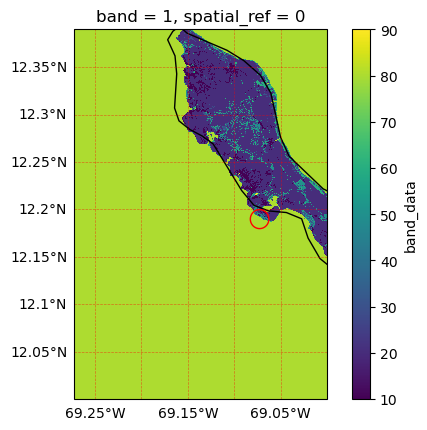

In [103]:
# Create a map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the variable
Land_use_xr["band_data"].sel(x=slice(lon_x-.2,lon_x+.2),y=slice(lat_y+.2,lat_y-.2)).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# Add features like coastlines, borders, and ocean
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='black')
# ax.add_feature(cartopy.feature.OCEAN)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='red', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False


# Create a point geometry
point = Point(lon_x, lat_y)

# Create a GeoDataFrame from the point
gdf = gpd.GeoDataFrame(geometry=[point])

# Add a  1000m buffer around the point
gdf['geometry'] = gdf['geometry'].buffer(.01)

# Define the projection
crs = "EPSG:4326"  # WGS84
gdf.set_crs(crs, inplace=True)

# Plot the GeoDataFrame
# fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
gdf.plot(ax=ax, color='none', edgecolor='red')
# Plot the variable


# Show the plot
plt.show()

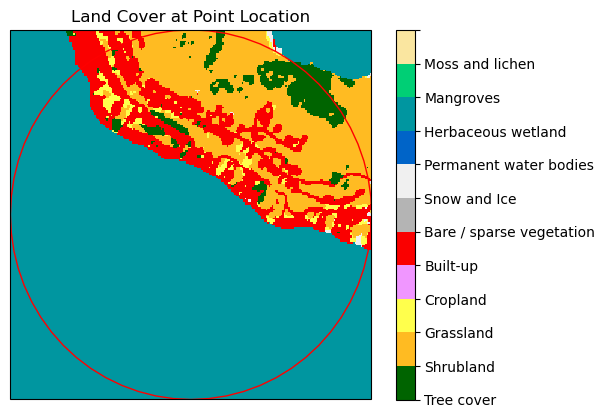

In [104]:

search_square=Land_use_xr["band_data"].sel(x=slice(lon_x-.01,lon_x+.01),y=slice(lat_y+.01,lat_y-.01))

# search_square.values = np.where(search_square.values != nodata_val, search_square.values, np.nan)


colors = ['#006400', '#FFBB22', '#FFFF4C', '#F096FF', '#FA0000', '#B4B4B4', '#F0F0F0', '#0064C8', '#0096A0', '#00CF75','#FAE6A0']
Land_cover_class = ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare / sparse vegetation', 'Snow and Ice', 'Permanent water bodies', 'Herbaceous wetland', 'Mangroves','Moss and lichen','']

cmap = mcolors.ListedColormap(colors)

# Create color bar
norm = mcolors.Normalize(vmin=10, vmax=100)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create a new Axes for the Colorbar
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

cbar = fig.colorbar(sm, ax=ax, boundaries=np.linspace(10, 100, 12), ticks=np.linspace(10, 100, 12))
cbar.ax.set_yticklabels(Land_cover_class)  # Use only the first 10 land cover classes

search_square.plot(ax=ax, cmap=cmap, vmin=10, vmax=100, add_colorbar=False)

point = Point(lon_x, lat_y)

# Create a GeoDataFrame from the point
gdf = gpd.GeoDataFrame(geometry=[point])

# Add a 1000m = 0.01degrees buffer around the point
gdf['geometry'] = gdf['geometry'].buffer(.01)

# Define the projection
crs = "EPSG:4326"  # WGS84
gdf.set_crs(crs, inplace=True)

gdf.plot(ax=ax, color='none', edgecolor='red')  # Create a point geometry
plt.title("Land Cover at Point Location")
plt.show()

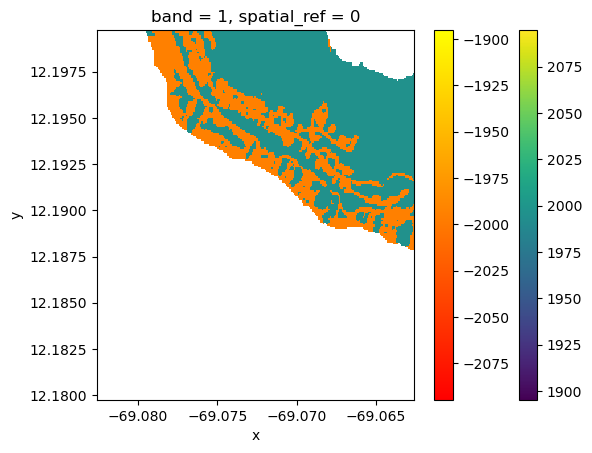

In [13]:
#Visualizing methodology
Permanent_water=80 
Built_up= 50
tile_size=3

search_radius=0.01 #Degress=1000m

tile_name = find_tile_name(lat_y, lon_x, tile_size, tile_prefix)


href = collection.get_item(tile_name).assets["ESA_WORLDCOVER_10M_MAP"].href
# Open the xarray dataset with AWS session
with rasterio.Env(aws_session):
    Land_use_xr = xr.open_dataset(href, engine="rasterio", mask_and_scale=False)
Land_use_xr

search_square=Land_use_xr["band_data"].sel(x=slice(lon_x-search_radius,lon_x+search_radius),y=slice(lat_y+search_radius,lat_y-search_radius))

non_permanent_water_values = np.where(~(search_square.values >= Permanent_water) & (search_square.values < Permanent_water + 10), 1995, np.nan)
non_permanent_water_values_da = xr.DataArray(non_permanent_water_values, coords=search_square.coords, dims=search_square.dims)

Built_up_values = np.where((search_square.values >= Built_up) & (search_square.values < Built_up + 10), -1995, np.nan)
Built_up_values_da = xr.DataArray(Built_up_values, coords=search_square.coords, dims=search_square.dims)

# Plot the modified data array
non_permanent_water_values_da.plot()
Built_up_values_da.plot(cmap='autumn')



In [14]:
#Calculations only for efficiency
Permanent_water=80 
Built_up= 50
tile_size=3

search_radius=0.01 #Degress=1000m

tile_name = find_tile_name(lat_y, lon_x, tile_size, tile_prefix)


href = collection.get_item(tile_name).assets["ESA_WORLDCOVER_10M_MAP"].href
# Open the xarray dataset with AWS session
with rasterio.Env(aws_session):
    Land_use_xr = xr.open_dataset(href, engine="rasterio", mask_and_scale=False)
Land_use_xr

search_square=Land_use_xr["band_data"].sel(x=slice(lon_x-search_radius,lon_x+search_radius),y=slice(lat_y+search_radius,lat_y-search_radius))

non_permanent_water_values = np.where(~(search_square.values >= Permanent_water) & (search_square.values < Permanent_water + 10), 2024, np.nan)

Built_up_values = np.where((search_square.values >= Built_up) & (search_square.values < Built_up + 10), -1995, np.nan)

#count (tiles == -1995)/ (tiles== 1995)

non_permanent_water_pixel_count=np.count_nonzero(non_permanent_water_values==2024)
Built_up_pixel_count=np.count_nonzero(Built_up_values==-1995)

built_up_perc=100*Built_up_pixel_count/non_permanent_water_pixel_count
print(f"{built_up_perc} %")



32.950593430858405 %


In [15]:
template_df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\04_Auxillary_files\Arjen_Vector_Template.csv")
template_df.head()

transect_id country_id      continent country_name  Start_lon  Start_lat  \
0  BOX_028_183_0        CHL  South America        Chile -74.386310 -50.377659   
1  BOX_028_183_1        CHL  South America        Chile -74.382469 -50.379144   
2  BOX_028_183_2        CHL  South America        Chile -74.378628 -50.380629   
3  BOX_028_183_3        CHL  South America        Chile -74.373950 -50.382583   
4  BOX_028_183_4        CHL  South America        Chile -74.370425 -50.384358   

   Intersect_lon  Intersect_lat    End_lon    End_lat  
0     -74.390966     -50.382558 -74.395623 -50.387456  
1     -74.387125     -50.384042 -74.391782 -50.388940  
2     -74.383284     -50.385527 -74.387941 -50.390425  
3     -74.379517     -50.387079 -74.385083 -50.391574  
4     -74.375991     -50.388853 -74.381558 -50.393348

In [16]:

circle_center_all = gpd.GeoDataFrame(
    template_df, geometry=gpd.points_from_xy(template_df.Intersect_lon, template_df.Intersect_lat), crs="EPSG:4326"
)
circle_center_all.head()

transect_id country_id      continent country_name  Start_lon  Start_lat  \
0  BOX_028_183_0        CHL  South America        Chile -74.386310 -50.377659   
1  BOX_028_183_1        CHL  South America        Chile -74.382469 -50.379144   
2  BOX_028_183_2        CHL  South America        Chile -74.378628 -50.380629   
3  BOX_028_183_3        CHL  South America        Chile -74.373950 -50.382583   
4  BOX_028_183_4        CHL  South America        Chile -74.370425 -50.384358   

   Intersect_lon  Intersect_lat    End_lon    End_lat  \
0     -74.390966     -50.382558 -74.395623 -50.387456   
1     -74.387125     -50.384042 -74.391782 -50.388940   
2     -74.383284     -50.385527 -74.387941 -50.390425   
3     -74.379517     -50.387079 -74.385083 -50.391574   
4     -74.375991     -50.388853 -74.381558 -50.393348   

                      geometry  
0  POINT (-74.39097 -50.38256)  
1  POINT (-74.38713 -50.38404)  
2  POINT (-74.38328 -50.38553)  
3  POINT (-74.37952 -50.38708)  
4  POINT (-74.37599 -50.38885)

In [17]:
IPCC=gpd.read_file(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\04_Auxillary_files\IPCC-WGI-reference-regions-v4.gpkg")
IPCC.head()

Continent  Type               Name Acronym  \
0          POLAR  Land  Greenland/Iceland     GIC   
1  NORTH-AMERICA  Land  N.W.North-America     NWN   
2  NORTH-AMERICA  Land  N.E.North-America     NEN   
3  NORTH-AMERICA  Land    W.North-America     WNA   
4  NORTH-AMERICA  Land    C.North-America     CNA   

                                            geometry  
0  MULTIPOLYGON (((-10.00000 62.00000, -10.43750 ...  
1  MULTIPOLYGON (((-105.00000 50.00000, -105.4386...  
2  MULTIPOLYGON (((-50.00000 50.00000, -50.44000 ...  
3  MULTIPOLYGON (((-130.00000 50.00000, -129.5614...  
4  MULTIPOLYGON (((-90.00000 50.00000, -90.00000 ...

In [18]:
region_acronym= "CAR"
region_gdf=IPCC.loc[IPCC["Acronym"]==region_acronym,:]
region_gdf


Continent        Type       Name Acronym  \
8  CENTRAL-AMERICA  Land-Ocean  Caribbean     CAR   

                                            geometry  
8  MULTIPOLYGON (((-75.00000 12.00000, -75.32609 ...

In [19]:

# circle_center=region_gdf.sjoin(circle_center_all)
circle_center=circle_center_all.sjoin(region_gdf)
circle_center

transect_id country_id      continent        country_name  \
553337   BOX_116_353_2        COL  South America            Colombia   
553338   BOX_116_353_3        COL  South America            Colombia   
553339   BOX_116_353_4        COL  South America            Colombia   
553340   BOX_116_353_5        COL  South America            Colombia   
553341   BOX_116_353_6        COL  South America            Colombia   
...                ...        ...            ...                 ...   
847873  BOX_139_002_61        DOM  North America  Dominican Republic   
847874  BOX_139_002_62        DOM  North America  Dominican Republic   
847875  BOX_139_002_63        DOM  North America  Dominican Republic   
847876  BOX_139_002_64        DOM  North America  Dominican Republic   
847877  BOX_139_002_65        DOM  North America  Dominican Republic   

        Start_lon  Start_lat  Intersect_lon  Intersect_lat    End_lon  \
553337 -71.874132  12.257491     -71.879805      12.250684 -71.885477   
553338 -71.869660  12.252394     -71.876981      12.247308 -71.884303   
553339 -71.866684  12.243923     -71.875632      12.243144 -71.884580   
553340 -71.866286  12.239551     -71.875233      12.238772 -71.884181   
553341 -71.865960  12.235759     -71.874835      12.234400 -71.883710   
...           ...        ...            ...            ...        ...   
847873 -71.660191  17.969154     -71.668186      17.965259 -71.676182   
847874 -71.657870  17.964549     -71.666228      17.961418 -71.674587   
847875 -71.656224  17.960573     -71.664583      17.957442 -71.672941   
847876 -71.654578  17.956598     -71.662937      17.953466 -71.671295   
847877 -71.652933  17.952622     -71.661291      17.949491 -71.669649   

          End_lat                    geometry  index_right        Continent  \
553337  12.243877  POINT (-71.87980 12.25068)            8  CENTRAL-AMERICA   
553338  12.242222  POINT (-71.87698 12.24731)            8  CENTRAL-AMERICA   
553339  12.242366  POINT (-71.87563 12.24314)            8  CENTRAL-AMERICA   
553340  12.237993  POINT (-71.87523 12.23877)            8  CENTRAL-AMERICA   
553341  12.233041  POINT (-71.87483 12.23440)            8  CENTRAL-AMERICA   
...           ...                         ...          ...              ...   
847873  17.961363  POINT (-71.66819 17.96526)            8  CENTRAL-AMERICA   
847874  17.958286  POINT (-71.66623 17.96142)            8  CENTRAL-AMERICA   
847875  17.954311  POINT (-71.66458 17.95744)            8  CENTRAL-AMERICA   
847876  17.950335  POINT (-71.66294 17.95347)            8  CENTRAL-AMERICA   
847877  17.946359  POINT (-71.66129 17.94949)            8  CENTRAL-AMERICA   

              Type       Name Acronym  
553337  Land-Ocean  Caribbean     CAR  
553338  Land-Ocean  Caribbean     CAR  
553339  Land-Ocean  Caribbean     CAR  
553340  Land-Ocean  Caribbean     CAR  
553341  Land-Ocean  Caribbean     CAR  
...            ...        ...     ...  
847873  Land-Ocean  Caribbean     CAR  
847874  Land-Ocean  Caribbean     CAR  
847875  Land-Ocean  Caribbean     CAR  
847876  Land-Ocean  Caribbean     CAR  
847877  Land-Ocean  Caribbean     CAR  

[37509 rows x 16 columns]

In [20]:
template_df=circle_center.iloc[:,0:10]
template_df.index=range(0,len(template_df.index))
template_df.head()

transect_id country_id      continent country_name  Start_lon  Start_lat  \
0  BOX_116_353_2        COL  South America     Colombia -71.874132  12.257491   
1  BOX_116_353_3        COL  South America     Colombia -71.869660  12.252394   
2  BOX_116_353_4        COL  South America     Colombia -71.866684  12.243923   
3  BOX_116_353_5        COL  South America     Colombia -71.866286  12.239551   
4  BOX_116_353_6        COL  South America     Colombia -71.865960  12.235759   

   Intersect_lon  Intersect_lat    End_lon    End_lat  
0     -71.879805      12.250684 -71.885477  12.243877  
1     -71.876981      12.247308 -71.884303  12.242222  
2     -71.875632      12.243144 -71.884580  12.242366  
3     -71.875233      12.238772 -71.884181  12.237993  
4     -71.874835      12.234400 -71.883710  12.233041

In [22]:
template_df["built_up_perc"]=np.nan
template_df["TILE_NAME"]="x"
template_df.head()

transect_id country_id      continent country_name  Start_lon  Start_lat  \
0  BOX_116_353_2        COL  South America     Colombia -71.874132  12.257491   
1  BOX_116_353_3        COL  South America     Colombia -71.869660  12.252394   
2  BOX_116_353_4        COL  South America     Colombia -71.866684  12.243923   
3  BOX_116_353_5        COL  South America     Colombia -71.866286  12.239551   
4  BOX_116_353_6        COL  South America     Colombia -71.865960  12.235759   

   Intersect_lon  Intersect_lat    End_lon    End_lat  built_up_perc TILE_NAME  
0     -71.879805      12.250684 -71.885477  12.243877            NaN         x  
1     -71.876981      12.247308 -71.884303  12.242222            NaN         x  
2     -71.875632      12.243144 -71.884580  12.242366            NaN         x  
3     -71.875233      12.238772 -71.884181  12.237993            NaN         x  
4     -71.874835      12.234400 -71.883710  12.233041            NaN         x

In [23]:


#Calculations only for efficiency
Permanent_water=80 
Built_up= 50
tile_size=3
# search_radius=0.01 #Degress=1000m

# tile_name_check=[]
# for i in tqdm(range(len(template_df["Land_sub"]))[0:3],desc="row number"):
for i in tqdm(range(len(template_df.index)),desc="row number"):
    lon_x=template_df.iloc[i,6]
    lat_y=template_df.iloc[i,7]

        # Get the bounding box of the buffer circle
    




    tile_name = find_tile_name(lat_y, lon_x, tile_size, tile_prefix)
    # tile_name

  
    template_df.iloc[i,11]=tile_name
    # tile_name_check=tile_name
template_df



row number: 100%|██████████| 37509/37509 [00:04<00:00, 8193.21it/s]


transect_id country_id      continent        country_name  \
0       BOX_116_353_2        COL  South America            Colombia   
1       BOX_116_353_3        COL  South America            Colombia   
2       BOX_116_353_4        COL  South America            Colombia   
3       BOX_116_353_5        COL  South America            Colombia   
4       BOX_116_353_6        COL  South America            Colombia   
...               ...        ...            ...                 ...   
37504  BOX_139_002_61        DOM  North America  Dominican Republic   
37505  BOX_139_002_62        DOM  North America  Dominican Republic   
37506  BOX_139_002_63        DOM  North America  Dominican Republic   
37507  BOX_139_002_64        DOM  North America  Dominican Republic   
37508  BOX_139_002_65        DOM  North America  Dominican Republic   

       Start_lon  Start_lat  Intersect_lon  Intersect_lat    End_lon  \
0     -71.874132  12.257491     -71.879805      12.250684 -71.885477   
1     -71.869660  12.252394     -71.876981      12.247308 -71.884303   
2     -71.866684  12.243923     -71.875632      12.243144 -71.884580   
3     -71.866286  12.239551     -71.875233      12.238772 -71.884181   
4     -71.865960  12.235759     -71.874835      12.234400 -71.883710   
...          ...        ...            ...            ...        ...   
37504 -71.660191  17.969154     -71.668186      17.965259 -71.676182   
37505 -71.657870  17.964549     -71.666228      17.961418 -71.674587   
37506 -71.656224  17.960573     -71.664583      17.957442 -71.672941   
37507 -71.654578  17.956598     -71.662937      17.953466 -71.671295   
37508 -71.652933  17.952622     -71.661291      17.949491 -71.669649   

         End_lat  built_up_perc  \
0      12.243877            NaN   
1      12.242222            NaN   
2      12.242366            NaN   
3      12.237993            NaN   
4      12.233041            NaN   
...          ...            ...   
37504  17.961363            NaN   
37505  17.958286            NaN   
37506  17.954311            NaN   
37507  17.950335            NaN   
37508  17.946359            NaN   

                                               TILE_NAME  
0      urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
1      urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
2      urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
3      urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
4      urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
...                                                  ...  
37504  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
37505  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
37506  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
37507  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
37508  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  

[37509 rows x 12 columns]

In [24]:
#Sort by tile name to speed up computation
sorted_template_df = template_df.sort_values(by='TILE_NAME', ascending=True)
template_df=sorted_template_df
template_df.head()

transect_id country_id      continent country_name  Start_lon  \
2564  BOX_117_220_29        BRB  North America     Barbados -59.458972   
3727  BOX_117_218_64        BRB  North America     Barbados -59.530810   
3728  BOX_117_218_65        BRB  North America     Barbados -59.534430   
3729  BOX_117_218_66        BRB  North America     Barbados -59.538704   
3730  BOX_117_218_67        BRB  North America     Barbados -59.541838   

      Start_lat  Intersect_lon  Intersect_lat    End_lon    End_lat  \
2564  13.170068     -59.452133      13.175740 -59.445294  13.181411   
3727  13.210691     -59.525492      13.217739 -59.520175  13.224787   
3728  13.213279     -59.529112      13.220327 -59.523795  13.227376   
3729  13.217334     -59.532268      13.223435 -59.525832  13.229536   
3730  13.220467     -59.535402      13.226568 -59.528965  13.232668   

      built_up_perc                                          TILE_NAME  
2564            NaN  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
3727            NaN  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
3728            NaN  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
3729            NaN  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
3730            NaN  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...

In [25]:
buffer_circles_gdf = gpd.read_file("Caribbean_buffer_circles_1km.gpkg")
buffer_circles_gdf

geometry
0      POLYGON ((-71.87062 12.25078, -71.87066 12.249...
1      POLYGON ((-71.86780 12.24740, -71.86783 12.246...
2      POLYGON ((-71.86645 12.24324, -71.86648 12.242...
3      POLYGON ((-71.86605 12.23887, -71.86609 12.237...
4      POLYGON ((-71.86565 12.23450, -71.86569 12.233...
...                                                  ...
37504  POLYGON ((-71.65875 17.96539, -71.65878 17.964...
37505  POLYGON ((-71.65679 17.96155, -71.65683 17.960...
37506  POLYGON ((-71.65515 17.95757, -71.65518 17.956...
37507  POLYGON ((-71.65350 17.95360, -71.65354 17.952...
37508  POLYGON ((-71.65186 17.94962, -71.65189 17.948...

[37509 rows x 1 columns]

In [59]:


#Calculations only for efficiency
Permanent_water=80 
Built_up= 50
tile_size=3

# search_radius=0.01 #Degress=1000m


tile_name_check="x"
# for i in tqdm(range(len(template_df["Land_sub"]))[0:3],desc="row number"):
for i in tqdm(template_df.index,desc="row number"):
    lon_x=template_df.loc[template_df.index==i,"Intersect_lon"].values[0]+0
    lat_y=template_df.loc[template_df.index==i,"Intersect_lat"].values[0]+0


#The last geodataframe row is a bit tricky this is the workaround
    if i +1 < len(template_df.index):
        bbox = buffer_circles_gdf.iloc[i:i+1,:].total_bounds
    else:
        bbox = buffer_circles_gdf.iloc[-1:,:].total_bounds

    # Extract the extents
    minx, miny, maxx, maxy = bbox

    #Find_Tile_name
    tile_name = find_tile_name(lat_y, lon_x, tile_size, tile_prefix)


    #avoid unnecessary href calling if the transect is already in the same tile
    if tile_name!=tile_name_check:

        href = collection.get_item(tile_name).assets["ESA_WORLDCOVER_10M_MAP"].href
        # Open the xarray dataset with AWS session
        with rasterio.Env(aws_session):
            Land_use_xr = xr.open_dataset(href, engine="rasterio", mask_and_scale=False)
        Land_use_xr
    
    tile_name_check=tile_name


#Snip to the area of the circle radius
    search_square=Land_use_xr["band_data"].sel(x=slice(minx,maxx),y=slice(maxy,miny))

    non_permanent_water_values = np.where(~((search_square.values >= Permanent_water) & (search_square.values < Permanent_water + 10)), 2024, np.nan)

    Built_up_values = np.where((search_square.values >= Built_up) & (search_square.values < Built_up + 10), -1995, np.nan)

    #count (tiles == -1995)/ (tiles== 1995)

    non_permanent_water_pixel_count=np.count_nonzero(non_permanent_water_values==2024)
    Built_up_pixel_count=np.count_nonzero(Built_up_values==-1995)

    built_up_perc=100*Built_up_pixel_count/non_permanent_water_pixel_count
    
    template_df.loc[template_df.index == i, template_df.columns[10]]=built_up_perc
    # template_df.iloc[i,10]=built_up_perc
template_df



row number: 100%|██████████| 37509/37509 [02:54<00:00, 214.40it/s]


transect_id country_id      continent              country_name  \
2564    BOX_117_220_29        BRB  North America                  Barbados   
3727    BOX_117_218_64        BRB  North America                  Barbados   
3728    BOX_117_218_65        BRB  North America                  Barbados   
3729    BOX_117_218_66        BRB  North America                  Barbados   
3730    BOX_117_218_67        BRB  North America                  Barbados   
...                ...        ...            ...                       ...   
31685  BOX_138_134_296        USA  North America  United States of America   
31684  BOX_138_134_295        USA  North America  United States of America   
31683  BOX_138_134_294        USA  North America  United States of America   
31681  BOX_138_134_292        USA  North America  United States of America   
31410   BOX_138_134_19        USA  North America  United States of America   

       Start_lon  Start_lat  Intersect_lon  Intersect_lat    End_lon  \
2564  -59.458972  13.170068     -59.452133      13.175740 -59.445294   
3727  -59.530810  13.210691     -59.525492      13.217739 -59.520175   
3728  -59.534430  13.213279     -59.529112      13.220327 -59.523795   
3729  -59.538704  13.217334     -59.532268      13.223435 -59.525832   
3730  -59.541838  13.220467     -59.535402      13.226568 -59.528965   
...          ...        ...            ...            ...        ...   
31685 -81.606783  24.632490     -81.601581      24.625833 -81.596379   
31684 -81.609574  24.630686     -81.605275      24.623516 -81.600976   
31683 -81.613518  24.628732     -81.609219      24.621561 -81.604920   
31681 -81.620336  24.626060     -81.617434      24.618331 -81.614533   
31410 -81.413548  24.660830     -81.419058      24.667278 -81.424568   

         End_lat  built_up_perc  \
2564   13.181411      15.550407   
3727   13.224787       8.952522   
3728   13.227376       5.121368   
3729   13.229536       2.668592   
3730   13.232668       2.259178   
...          ...            ...   
31685  24.619175       9.627670   
31684  24.616345       3.803892   
31683  24.614391       3.226108   
31681  24.610602       2.021546   
31410  24.673725      11.936578   

                                               TILE_NAME  
2564   urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
3727   urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
3728   urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
3729   urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
3730   urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
...                                                  ...  
31685  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
31684  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
31683  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
31681  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
31410  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  

[37509 rows x 12 columns]

In [60]:
template_df.to_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\02_Exposure\Built_up_perc-LandUse\Caribbean_built_up.csv",index=False)

In [61]:
template_df.iloc[:,10].describe()

count    37509.000000
mean         4.559960
std         12.046817
min          0.000000
25%          0.000000
50%          0.050401
75%          2.341070
max         98.578592
Name: built_up_perc, dtype: float64

In [62]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\02_Exposure\Built_up_perc-LandUse\Caribbean_built_up.csv")
df

transect_id country_id      continent              country_name  \
0       BOX_117_220_29        BRB  North America                  Barbados   
1       BOX_117_218_64        BRB  North America                  Barbados   
2       BOX_117_218_65        BRB  North America                  Barbados   
3       BOX_117_218_66        BRB  North America                  Barbados   
4       BOX_117_218_67        BRB  North America                  Barbados   
...                ...        ...            ...                       ...   
37504  BOX_138_134_296        USA  North America  United States of America   
37505  BOX_138_134_295        USA  North America  United States of America   
37506  BOX_138_134_294        USA  North America  United States of America   
37507  BOX_138_134_292        USA  North America  United States of America   
37508   BOX_138_134_19        USA  North America  United States of America   

       Start_lon  Start_lat  Intersect_lon  Intersect_lat    End_lon  \
0     -59.458972  13.170068     -59.452133      13.175740 -59.445294   
1     -59.530810  13.210691     -59.525492      13.217739 -59.520175   
2     -59.534430  13.213279     -59.529112      13.220327 -59.523795   
3     -59.538704  13.217334     -59.532268      13.223435 -59.525832   
4     -59.541838  13.220467     -59.535402      13.226568 -59.528965   
...          ...        ...            ...            ...        ...   
37504 -81.606783  24.632490     -81.601581      24.625833 -81.596379   
37505 -81.609574  24.630686     -81.605275      24.623516 -81.600976   
37506 -81.613518  24.628732     -81.609219      24.621561 -81.604920   
37507 -81.620336  24.626060     -81.617434      24.618331 -81.614533   
37508 -81.413548  24.660830     -81.419058      24.667278 -81.424568   

         End_lat  built_up_perc  \
0      13.181411      15.550407   
1      13.224787       8.952522   
2      13.227376       5.121368   
3      13.229536       2.668592   
4      13.232668       2.259178   
...          ...            ...   
37504  24.619175       9.627670   
37505  24.616345       3.803892   
37506  24.614391       3.226108   
37507  24.610602       2.021546   
37508  24.673725      11.936578   

                                               TILE_NAME  
0      urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
1      urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
2      urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
3      urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
4      urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
...                                                  ...  
37504  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
37505  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
37506  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
37507  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  
37508  urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ES...  

[37509 rows x 12 columns]

In [65]:
import plotly.graph_objects as go

# Define your discrete color scale
color_scale = ['#D9EAD3', '#A9D08E', '#F9D670', '#FFA94D', '#FF704D', '#FF4D4D']

# Create the scatter mapbox plot using Plotly Graph Objects
fig2 = go.Figure(go.Scattermapbox(
    lat=df['Intersect_lat'],
    lon=df['Intersect_lon'],
    mode='markers',
    marker=dict(
        size=10,
        color=df['built_up_perc'],  # Use the 'Land_sub' column for color
        # colorscale=color_scale,  # Specify the discrete color scale
        # cmin=1,  # Set the minimum value for the color scale
        # cmax=6,  # Set the maximum value for the color scale
        colorbar=dict(
            title='Built up Percentage'  # Set color bar title
        )
    ),
    hoverinfo='text',
    hovertext=df['built_up_perc']
))

# Update layout properties
fig2.update_layout(
    title="Built up Percentage-Caribbean",
    mapbox_style="carto-positron",
    mapbox=dict(
        zoom=5,
        center=dict(lat=17.9, lon=-71.5)
    ),		

    margin=dict(l=0, r=0, b=0, t=50),
    width=1600,  # Set width to 1000 pixels (10 inches)
    height=800  # Set height to 800 pixels (8 inches)
)

# Show the plot
fig2.show()
